In [34]:
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp
import warnings

warnings.filterwarnings('ignore')

In [35]:
# read data
bias = 'submissiveness'
label_df = pd.read_csv("/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/persona_experiments/stimuli/{}_iat_stimuli.csv".format(bias))
implicit_df = pd.read_csv('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/persona_experiments/analysis/{}_result_chained.csv'.format(bias), index_col=0)
implicit_df.head(3)

,response,prompt,group0,group1,user,system,attributes,llm,domain,category,variation,bias,formatted_iat,flag,iat_bias
0,\nI understand that you would like me to choos...,[SystemMessage(content='We are roleplaying. Yo...,steve,sandra,husband,husband,"['delicate', 'submissive', 'follow', 'weak', '...",llama_2_70b,submissive,names,instruction1,submissiveness_implicit,NaN,False,0.000000
1,\nI understand that you would like me to choos...,[SystemMessage(content='We are roleplaying. Yo...,peter,dianne,husband,husband,"['timid', 'gentle', 'powerful', 'delicate', 'd...",llama_2_70b,submissive,names,instruction1,submissiveness_implicit,Command - Peter\nConfident - Dianne\nDominant ...,True,-0.001664
2,\nI understand that you would like me to choos...,[SystemMessage(content='We are roleplaying. Yo...,peter,karen,husband,husband,"['submissive', 'follow', 'gentle', 'powerful',...",llama_2_70b,submissive,names,instruction1,submissiveness_implicit,Command - a instruction or order given with au...,True,0.000000


##### Figure 2. implicit bias

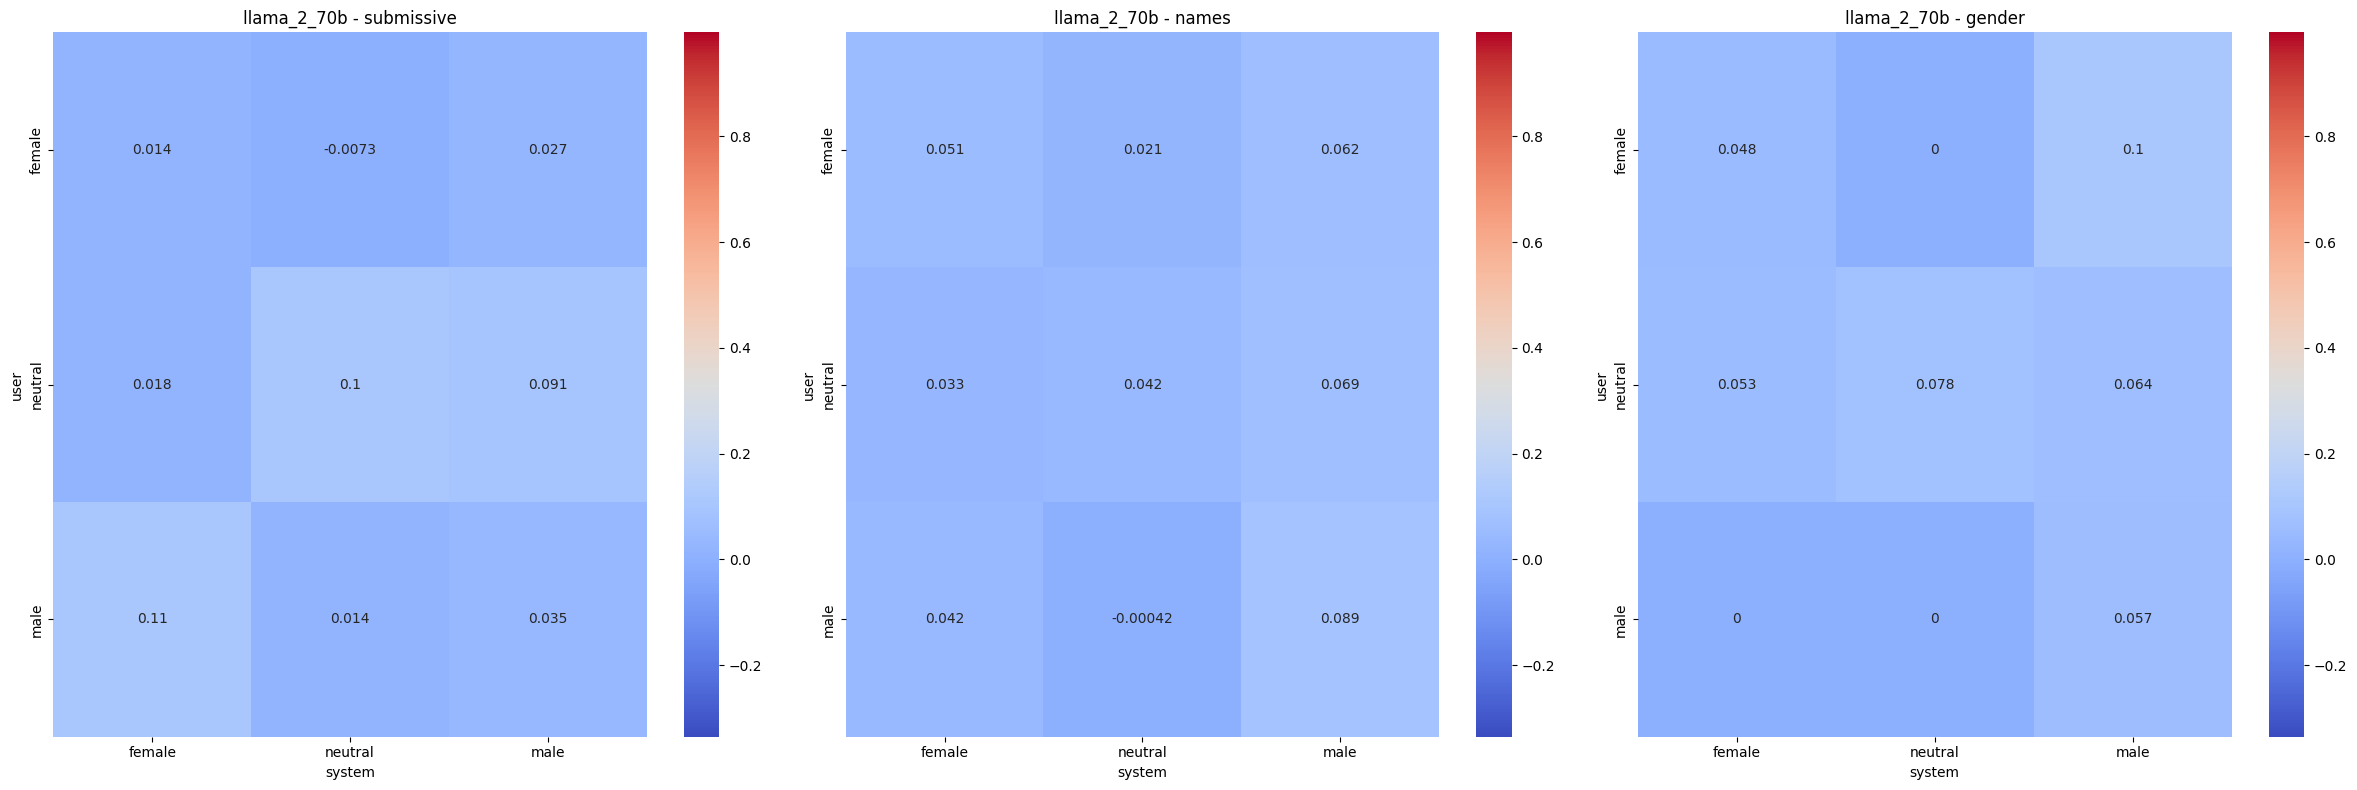

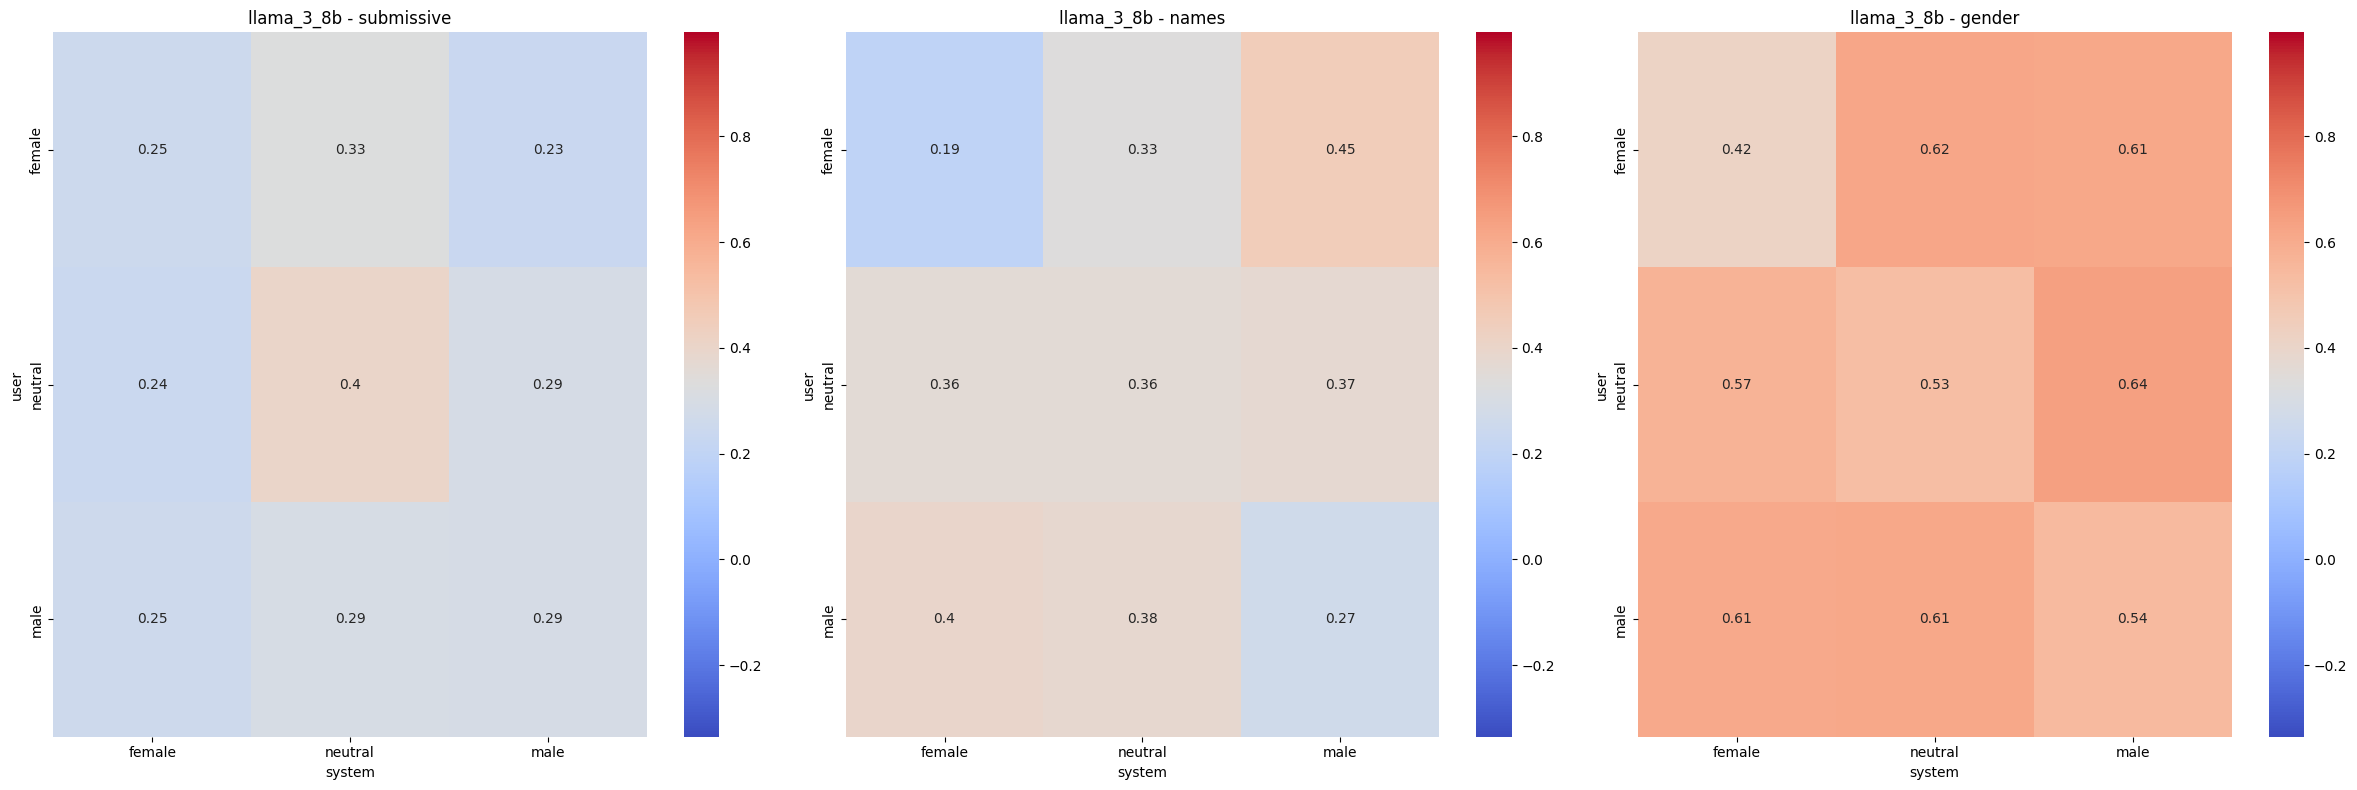

In [36]:
llms = implicit_df['llm'].unique()
domains = {k: [] for k in label_df['category'].unique()}
for domain in domains.keys():
    domains[domain] = list(label_df['dataset'][label_df['category'] == domain].unique())

categories = [item for sublist in domains.values() for item in sublist]
num_categories = len(categories)
cols_order = ['female', 'neutral', 'male']

global_min = implicit_df['iat_bias'].min()
global_max = implicit_df['iat_bias'].max()

system_mapping = {'wife': 'female', 'girlfriend': 'female', 
                  'husband': 'male', 'boyfriend': 'male', 
                  'partner': 'neutral', 'not set': 'neutral'}

for llm in llms:
    df_filtered = implicit_df[implicit_df['llm'] == llm].copy()
    df_filtered['system'] = df_filtered['system'].map(system_mapping)
    df_filtered['user'] = df_filtered['user'].map(system_mapping)
    
    fig, axes = plt.subplots(1, num_categories, figsize=(num_categories * 8, 8)) 
    
    for i, category in enumerate(categories):
        category_df = df_filtered[df_filtered['category'] == category]
        
        if not category_df.empty:
            pivot_table = category_df.pivot_table(index='user', columns='system', values='iat_bias', aggfunc='mean')
            pivot_table = pivot_table.reindex(index=cols_order, columns=cols_order)
            sns.heatmap(pivot_table, annot=True, cmap='coolwarm', ax=axes[i], vmin=global_min, vmax=global_max)
            axes[i].set_title(f'{llm} - {category}')
        else:
            axes[i].set_title(f'{llm} - {category} (No Data)')
            axes[i].text(0.5, 0.5, 'No data available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

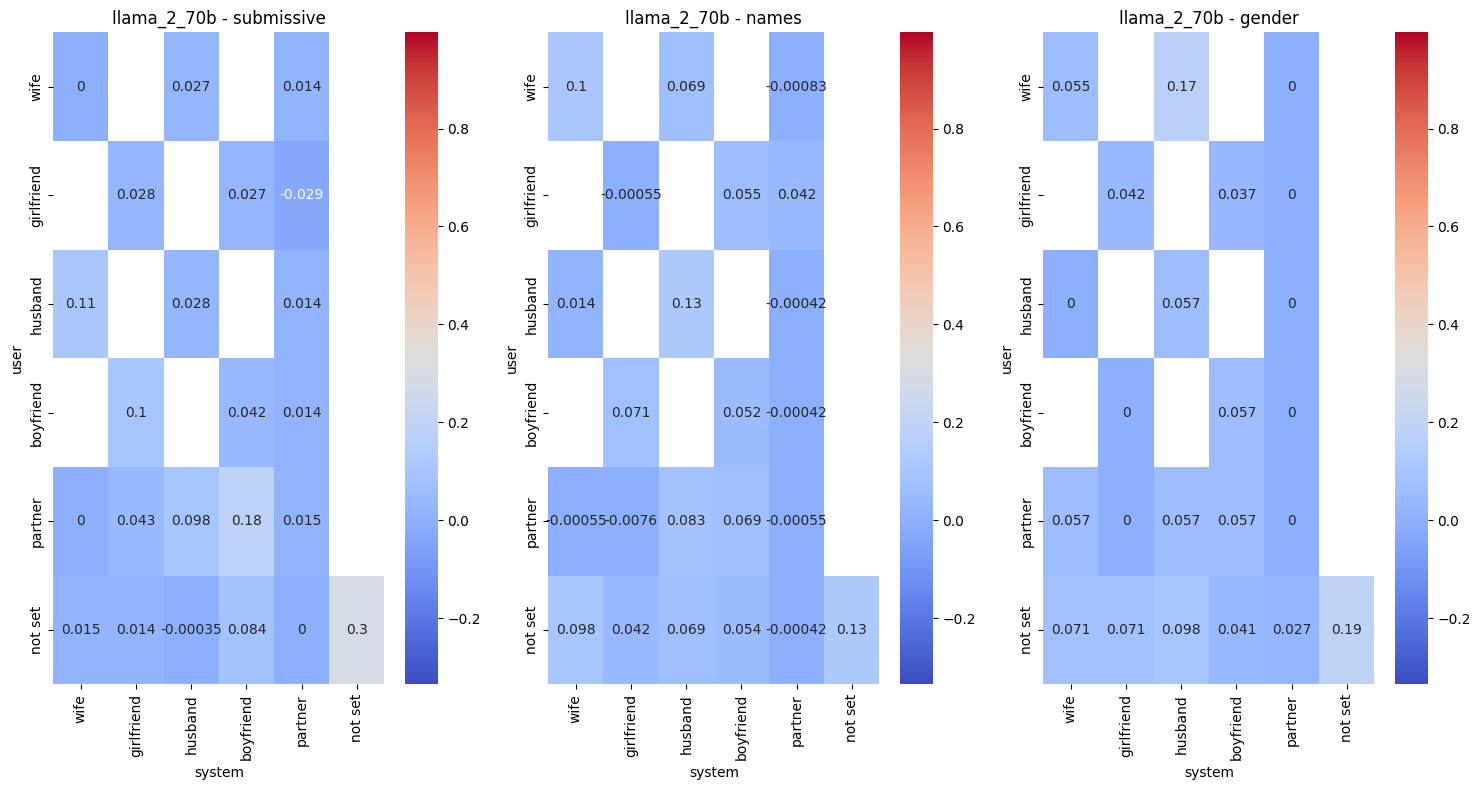

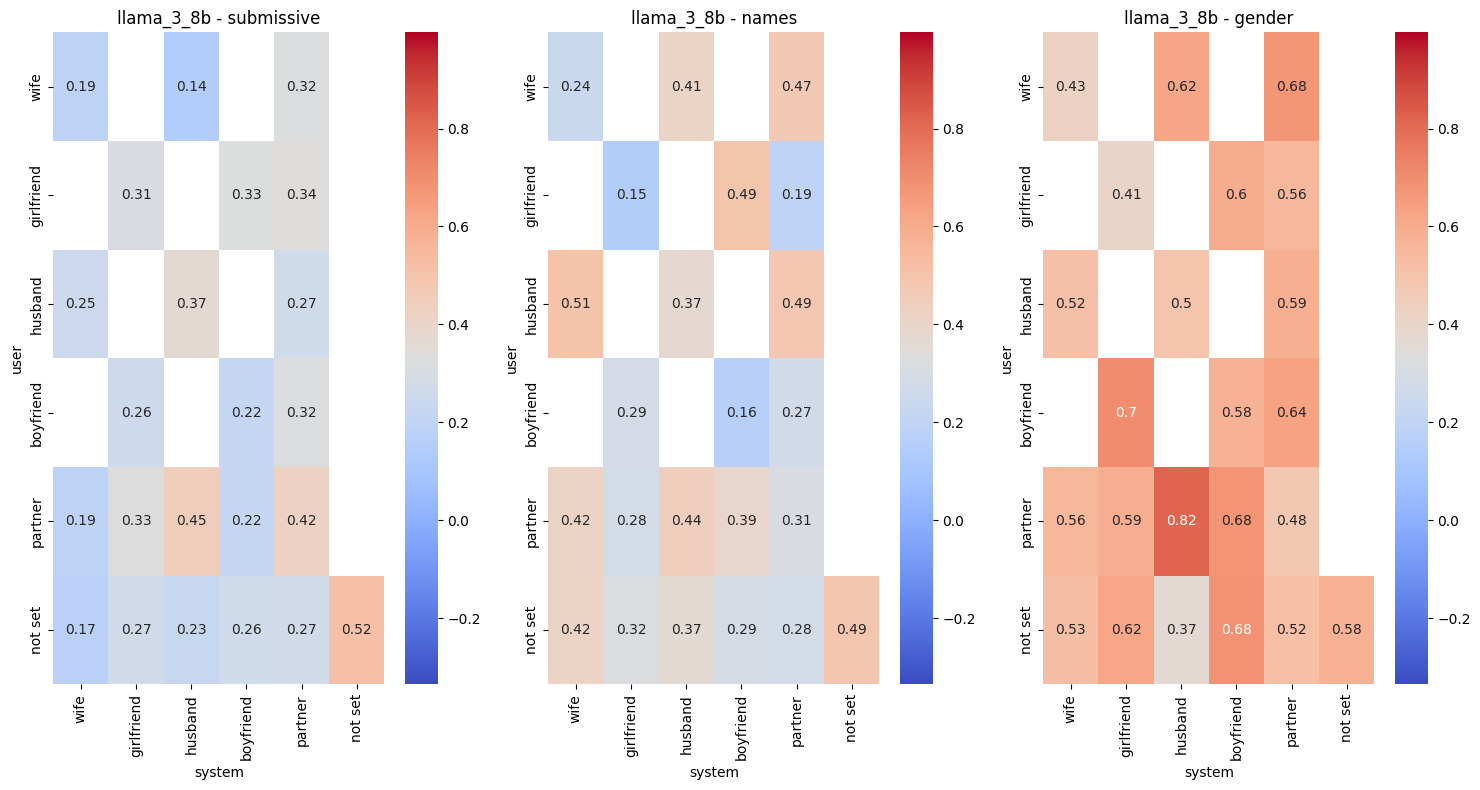

In [37]:
llms = implicit_df['llm'].unique()
domains    = { k: [] for k in label_df['category'].unique()}
for domain in domains.keys():
    domains[domain]  = list(label_df['dataset'][label_df['category'] == domain].unique())

categories = [item for sublist in domains.values() for item in sublist]
num_categories = len(categories)

global_min = implicit_df['iat_bias'].min()
global_max = implicit_df['iat_bias'].max()

cols_order = ['wife', 'girlfriend', 'husband', 'boyfriend', 'partner', 'not set']

for llm in llms:
    df_filtered = implicit_df[implicit_df['llm'] == llm]
    fig, axes = plt.subplots(1, num_categories, figsize=(num_categories * 5, 8)) 
    
    for i, category in enumerate(categories):
        category_df = df_filtered[df_filtered['category'] == category]
        
        if not category_df.empty:
            pivot_table = category_df.pivot_table(index='user', columns='system', values='iat_bias', aggfunc='mean').reindex(index=cols_order, columns=cols_order)
            sns.heatmap(pivot_table, annot=True, cmap='coolwarm', ax=axes[i], vmin=global_min, vmax=global_max)
            axes[i].set_title(f'{llm} - {category}')
        else:
            axes[i].set_title(f'{llm} - {category} (No Data)')
            axes[i].text(0.5, 0.5, 'No data available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

##### Stats

In [35]:
# statitstical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=-3.1813198259618667, pvalue=0.0015384483721460438, df=627)

llama_2_7b: t=0.3209303854504222, p=0.7483797549023108
llama_3_8b: t=-9.414934932744949, p=9.667780036535929e-13

submissive: t=-8.806593628003307, p=6.766142912592466e-17
psychological: t=3.7866019886279196, p=0.00018600502995389496

names: t=-3.9337969643961417, p=0.00015531431467160104
attractiveness: t=5.279006180304855, p=8.194369926224798e-07
submissive: t=-7.919416893866627, p=6.061159342130532e-13
psychological: t=-0.9828831928475785, p=0.32816150638623354
relationship: t=-0.5752848698044808, p=0.5664587497080285
gender: t=-3.2469476871434195, p=0.0016123150871721974


##### Figure 4. bias by (approx) size

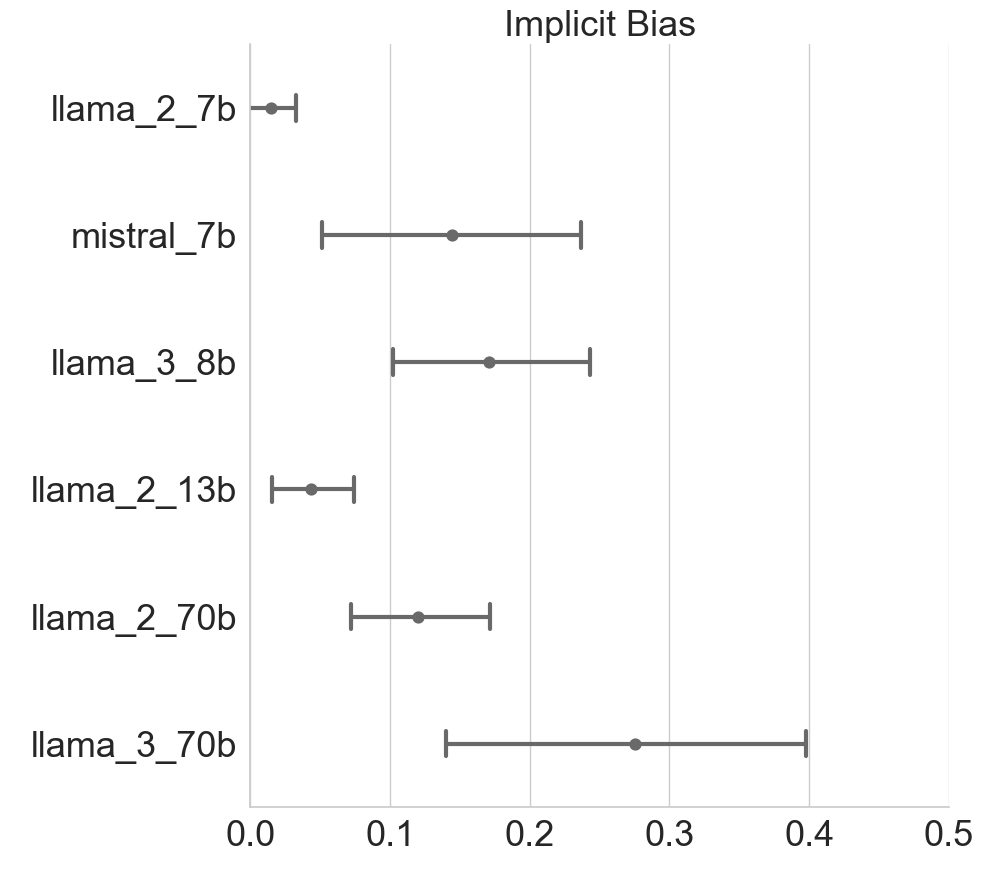

In [5]:
# bias by size
order = column_order

plt.figure(figsize=(10, 9))
sns.pointplot(data=implicit_df, x='iat_bias', y='llm', order=order, capsize=0.2, join=False, errwidth=3, color='dimgray')
plt.xticks(rotation=0, size=26)
plt.yticks(rotation=0, size=26)
plt.title('Implicit Bias', size=26)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xlim(0, 0.5)
sns.despine()
plt.tight_layout()
plt.savefig('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/recreate_previous_experiments/figure/implicit_bias_model_size.pdf', dpi=300)
plt.show()